<a href="https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Inverse_Kinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 Degree of Freedrom Robot Arm Inverse Kinematics

## Establish lengths between joints

In [ ]:
FloorToFirstJoint = 2.61*0.0254
UpperArmLength = 5.74*0.0254
ForeArmLength = 7.23*0.0254
GripperLength = 4.43*0.0254


## Establish Coordinate Systems and Solve Base Axis

First we will establish the base coordinate system for the robot arm. +Z is oriented vertically up through teh base of the robot arm, +X is in front of the robot arm when the base is 90 degrees, and +Y is the to the right of the robot arm when looking right at it.

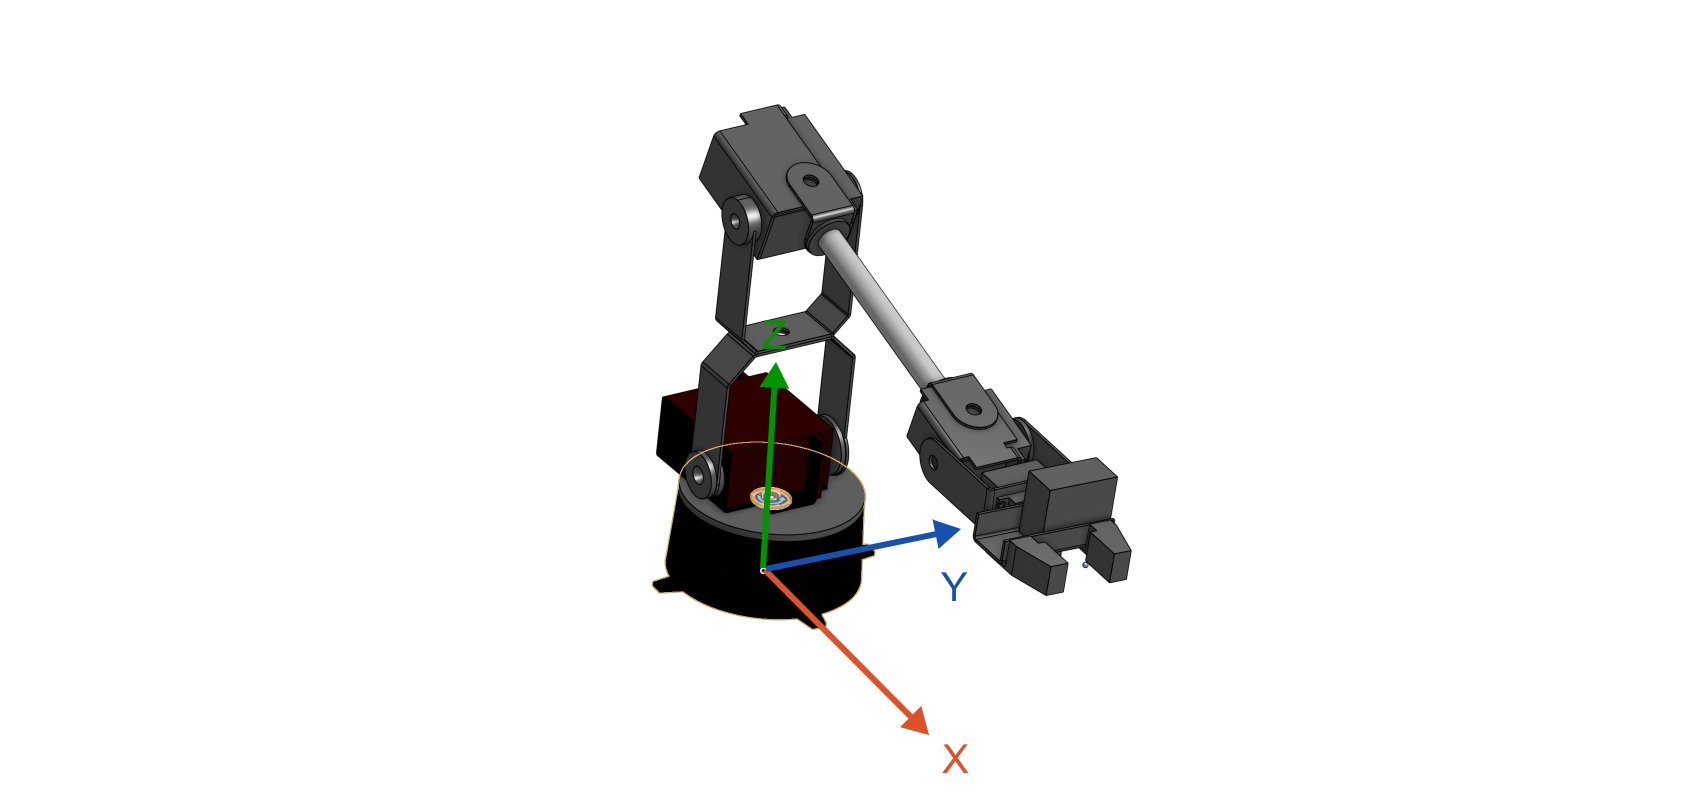

To solve the angle Theta of the base axis, we will look at the end effector position projected on the Z=0 plane.

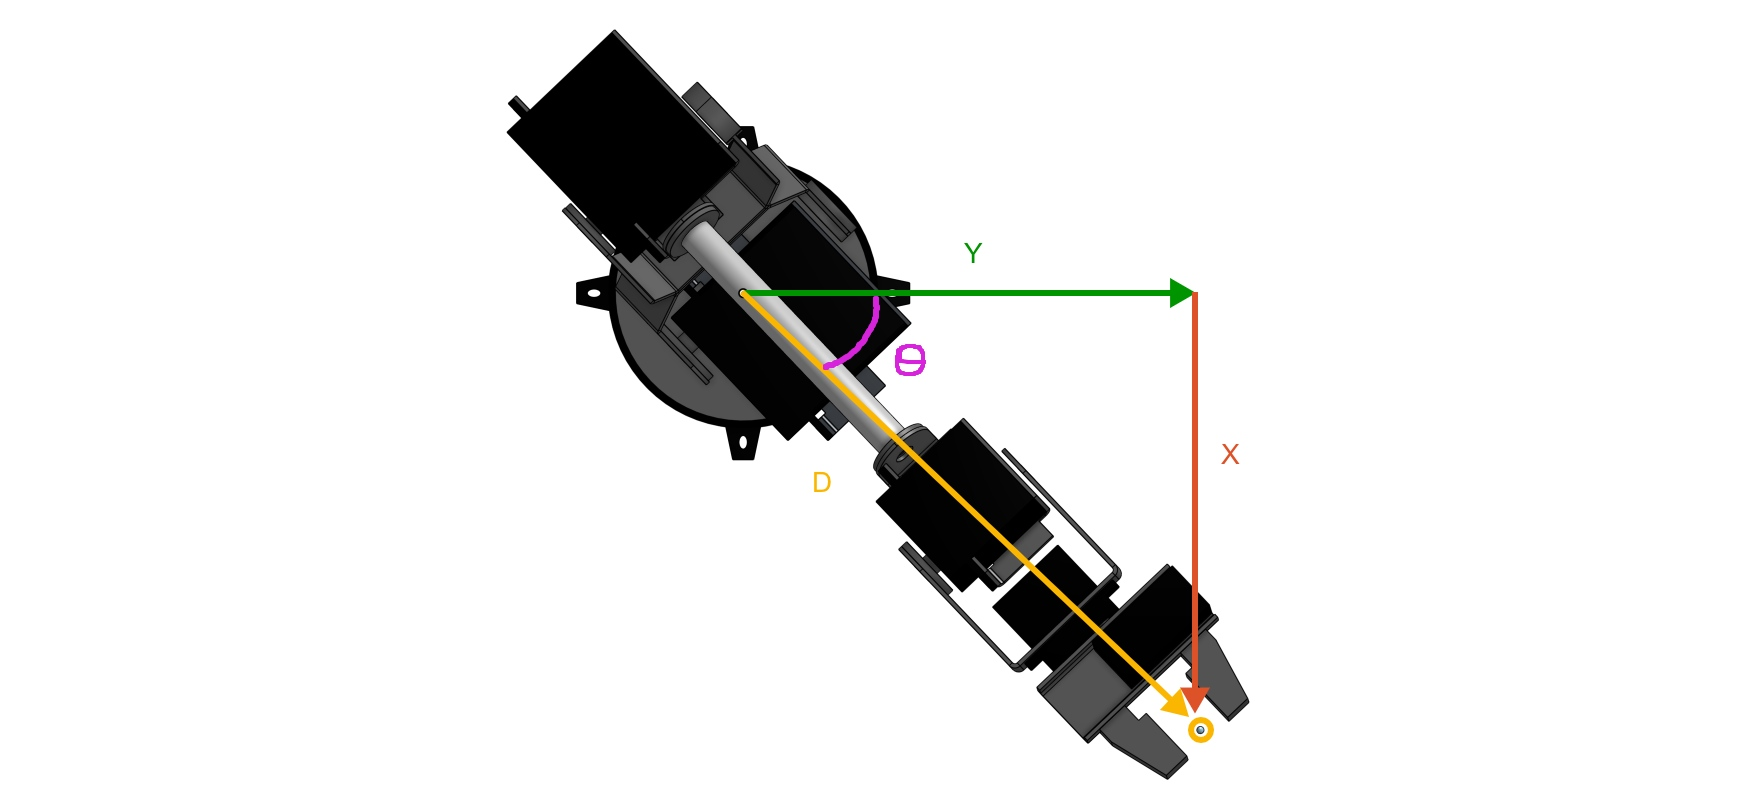

In [ ]:
import math
DegToRad = math.pi/180
RadToDeg = 180/math.pi

def GetBaseAng(x,y):
  BaseAngle = math.atan2(x,y)
  D = math.sqrt(x**2 + y**2)
  return BaseAngle, D
print(GetBaseAng(2,-1))

(2.0344439357957027, 2.23606797749979)


Now we can make a new coordinate system, PQ, with Q in the direction of the arm with the base rotation, and P along the Z axis, but offset by the height of the shoulder axis. [This video](https://www.youtube.com/watch?v=IKOGwoJ2HLk&t=1s) descibes how to solve the now 2DOF robot arm inverse kinematics in the PQ Plane. 
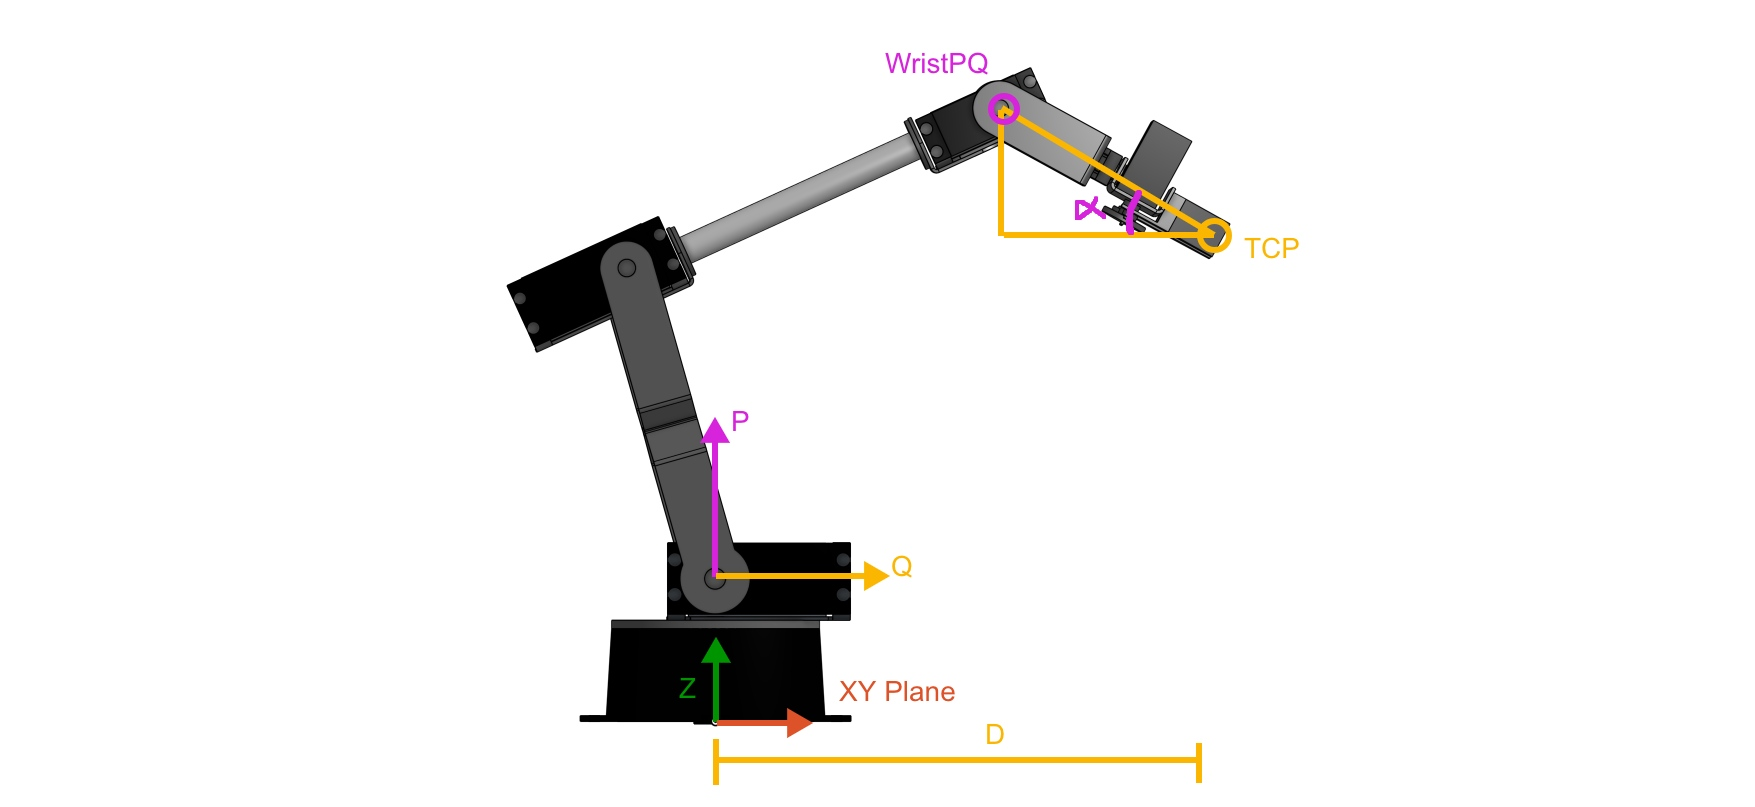

Alpha is the angle of the wrist with the horizontal plane in degrees (0 degrees flat, 90 degrees gripper pointing down), and is an input set by the user. We can find the position of the wrist joint in the PQ plane based on the XYZ position of the tool center point (TCP) and the distance D calculated in the function above.

In [ ]:
TCPx = 1
TCPy = 1
TCPz = 1
WristAngle = 30

def GetWristPQ(TCPx,TCPy,TCPz,WristAngle):
  BaseAngle, D = GetBaseAng(TCPx,TCPy)

  TCPq = D
  TCPp = TCPz - FloorToFirstJoint

  WristP = TCPp + GripperLength*math.sin(WristAngle*DegToRad)
  WristQ = TCPq - GripperLength*math.cos(WristAngle*DegToRad)

  return WristP, WristQ

print(GetWristPQ(0.2,0.2,0.2,30))




(0.189967, 0.18539580198998645)


Now we can set up the equations to solve for the shoulder and elbow angles. 

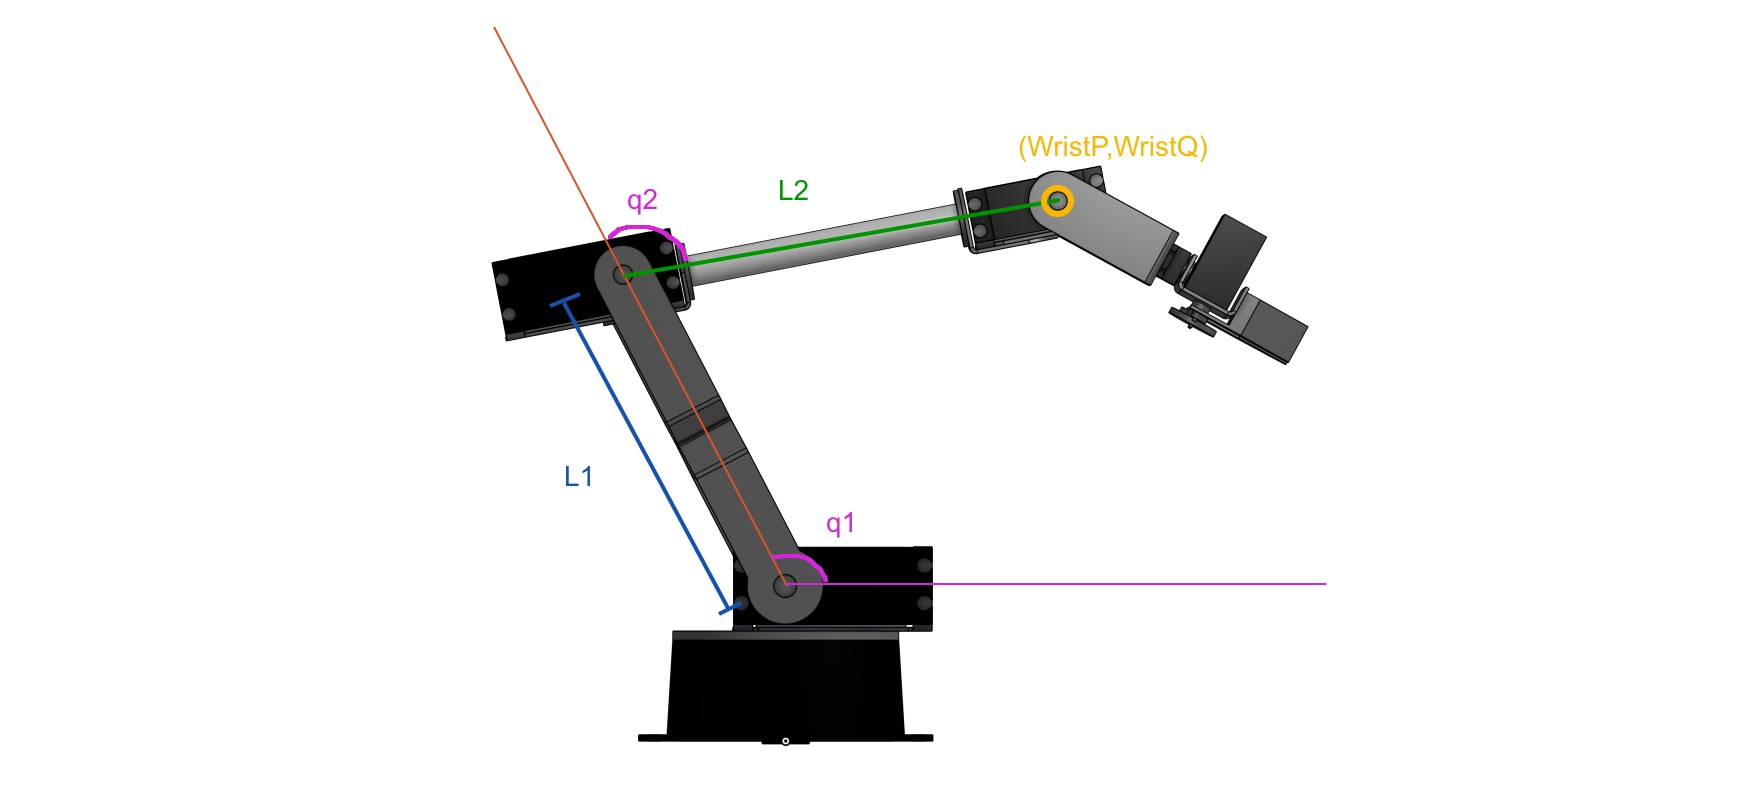

We can use the cosine rule to determine angle Beta between the upperarm (L1) and the forearm (L2).

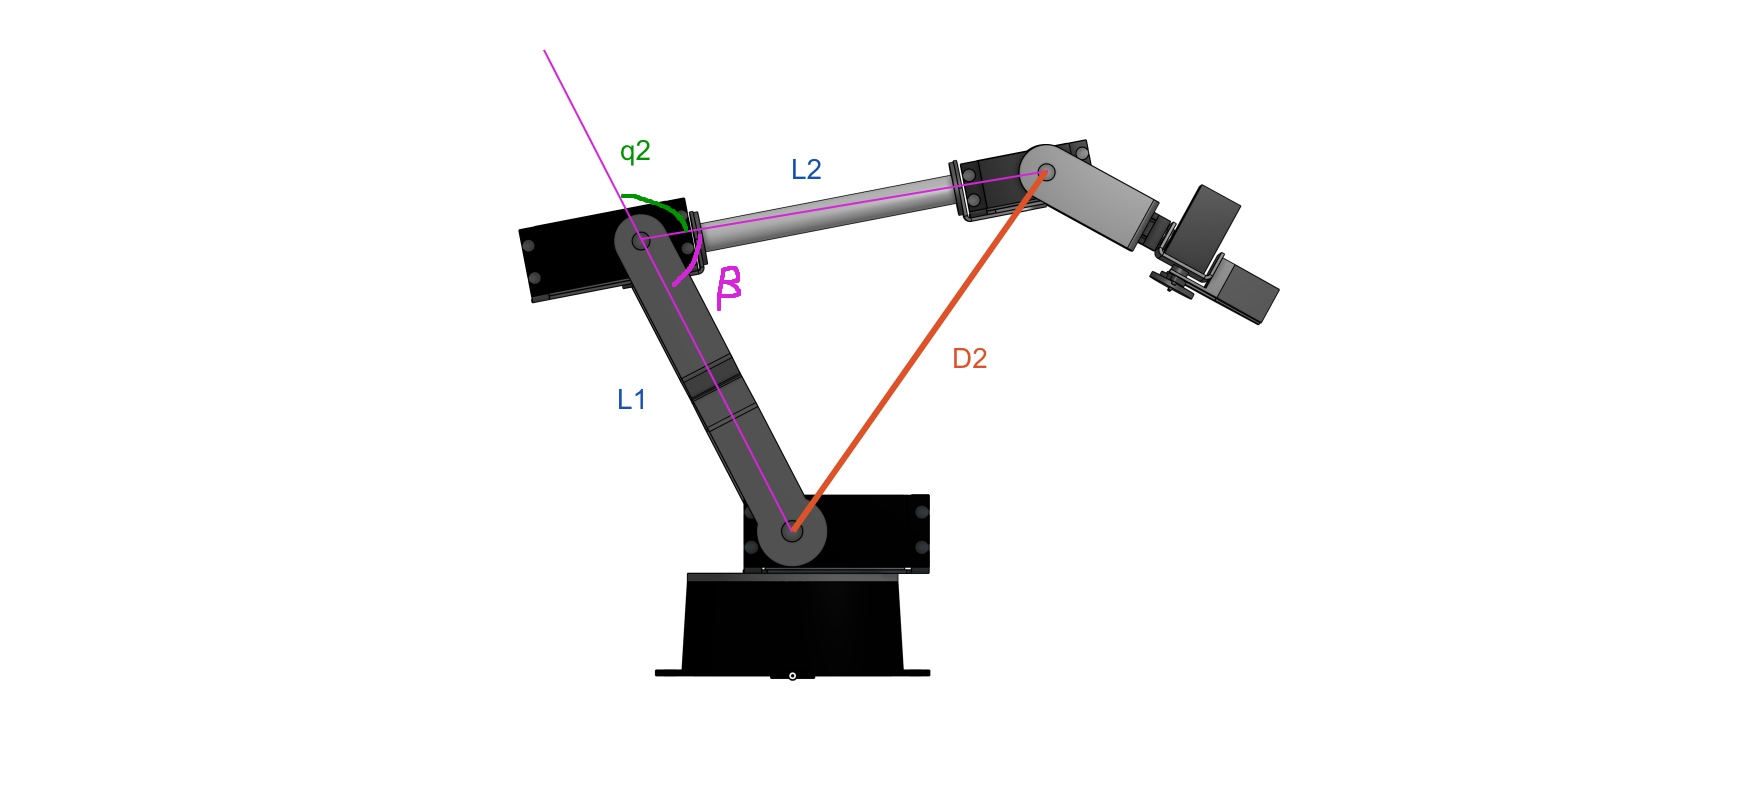

In [ ]:
def GetElbowAng(WristPz,WristQx):
  D2 = math.sqrt(WristPz**2 + WristQx**2)
  arg = (WristPz**2 + WristQx**2 - UpperArmLength**2 - ForeArmLength**2)/(2*UpperArmLength*ForeArmLength)
  Beta = math.acos((WristPz**2 + WristQx**2 - UpperArmLength**2 - ForeArmLength**2)/(2*UpperArmLength*ForeArmLength))
  return Beta

print(GetElbowAng(0.2, 0.2))

1.084648361873491


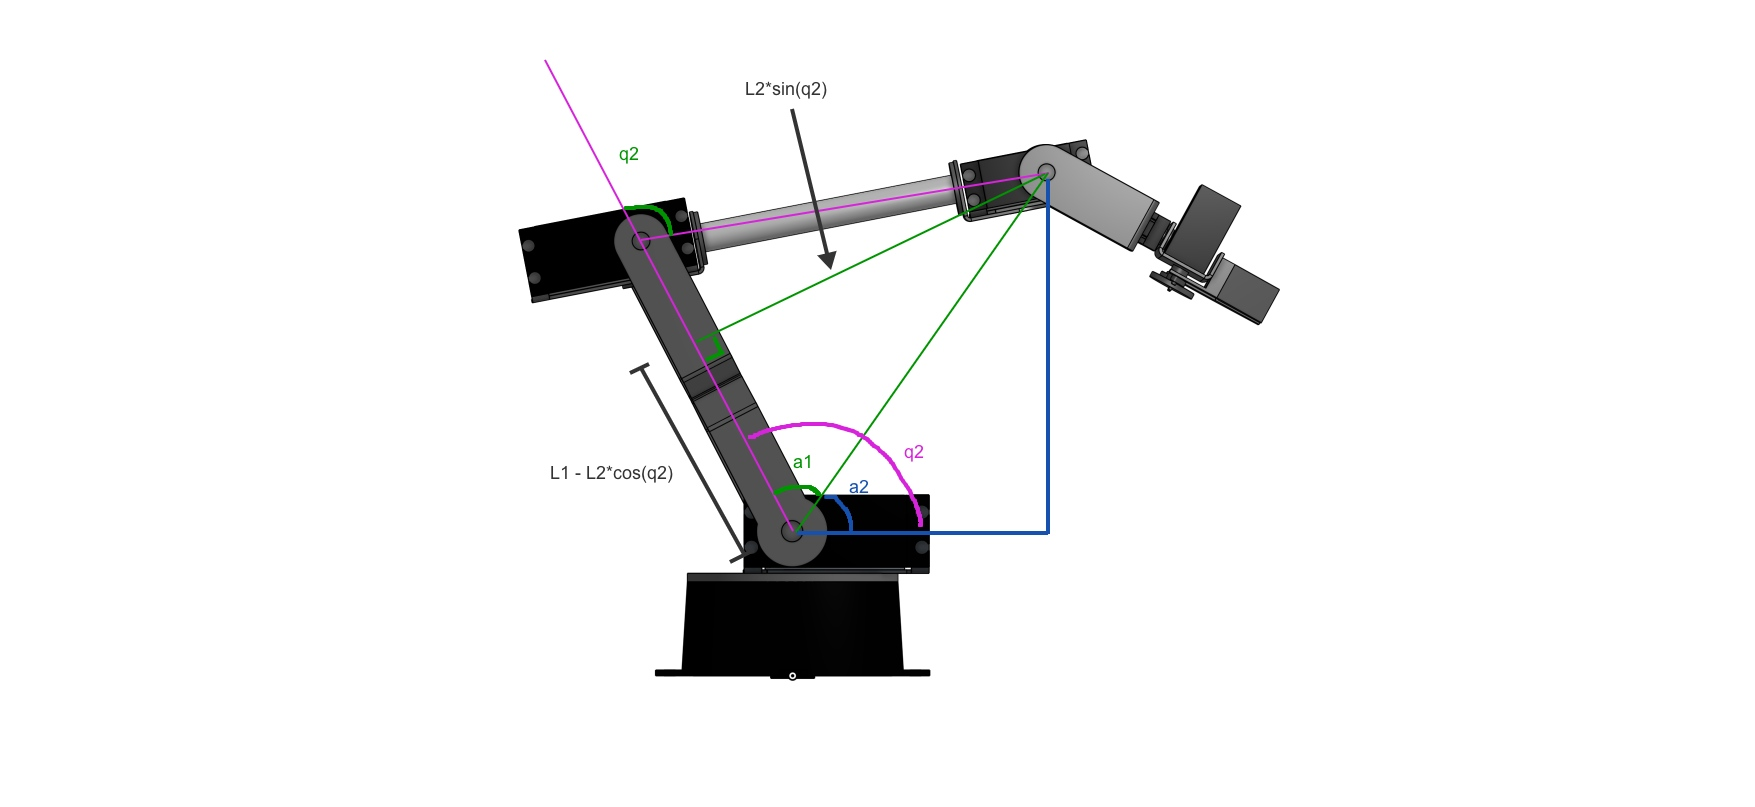

Now to solve the shoulder angle, q2, we need to find the angles a1 and a2, which can each be found with a simple arc tangent.

In [ ]:
def GetShoulderAng(q2,WristP,WristQ):
  a1 = math.atan2(ForeArmLength*math.sin(q2),UpperArmLength - ForeArmLength*math.cos(q2))
  a2 = math.atan2(WristP,WristQ)
  ShoulderAngle = a1 + a2
  return ShoulderAngle


Finally we get the wrist angle relative to the forearm

In [ ]:
print(2**4, math.pow(2,4), math.atan2(1,-2)*RadToDeg)

16 16.0 153.434948822922


In [ ]:
def GetWristAng(ShoulderAngle,ElbowAngle,WristAngle):
  WristAngleOut = ShoulderAngle + ElbowAngle + WristAngle*DegToRad + math.pi/2
  return WristAngleOut

Put it all together

In [ ]:
def Main(TCPx,TCPy,TCPz,WristAngle):
  BaseAngle, D = GetBaseAng(TCPx,TCPy)
  WristP, WristQ = GetWristPQ(TCPx,TCPy,TCPz,WristAngle)
  ElbowAngle = GetElbowAng(WristP,WristQ)
  ShoulderAngle = GetShoulderAng(ElbowAngle,WristP,WristQ)
  WristAngleOut = GetWristAng(ShoulderAngle,ElbowAngle,WristAngle)
  print(BaseAngle*RadToDeg, ElbowAngle*RadToDeg, ShoulderAngle*RadToDeg, WristAngleOut*RadToDeg)
  return [BaseAngle, ShoulderAngle, ElbowAngle, WristAngleOut]

print(Main(0.2,0.1,0.2,0))

63.43494882292201 76.06408991209686 91.20067656533806 257.2647664774349
[1.1071487177940904, 1.3275688114990944, 1.5917520861115824, 4.490117224405573]


# Send to Onshape

## Import and configure client

In [ ]:
!pip install onshape-client
from onshape_client.client import Client
import json
base = 'https://cad.onshape.com' # change this if you're using a document in an enterprise (i.e. "https://ptc.onshape.com")

In [ ]:
import os
def include(filename):
    if os.path.exists(filename): 
        execfile(filename)
include('colabkeys.py')
client = Client(configuration={"base_url": base,
                               "access_key": access,
                               "secret_key": secret})
print('client configured')

client configured


## Function for updating the mate values of the robot in Onshape

In [ ]:
def MateValues(RobotData):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'

  # https://cad.onshape.com/documents/4bda16c648566259ea1b4e4c/w/c299b9fc994574c2637e871d/e/2f52bf4870f9d7ddc900b4de
  did = '4bda16c648566259ea1b4e4c'
  wid = 'c299b9fc994574c2637e871d'
  eid = '2f52bf4870f9d7ddc900b4de'

  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
            'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', did)
  fixed_url = fixed_url.replace('wid', wid)
  fixed_url = fixed_url.replace('eid', eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
  fullResponse = json.loads(response.data)

  for i in range(len(fullResponse["mateValues"])):
    if fullResponse['mateValues'][i]['mateName'] == "Base":
      fullResponse['mateValues'][i]['rotationZ'] = RobotData[0]
    elif fullResponse['mateValues'][i]['mateName'] == "Shoulder":
      fullResponse['mateValues'][i]['rotationZ'] = RobotData[1]
    elif fullResponse['mateValues'][i]['mateName'] == "Elbow":
      fullResponse['mateValues'][i]['rotationZ'] = RobotData[2]
    elif fullResponse['mateValues'][i]['mateName'] == "Wrist":
      print('platypus')
      fullResponse['mateValues'][i]['rotationZ'] = RobotData[3]

  method = 'POST'

  params = {}
  payload = fullResponse
  headers = {'Accept': 'application/vnd.onshape.v2+json',
            'Content-Type': 'application/vnd.onshape.v2+json'}
  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  # The command below prints the entire JSON response from Onshape
  print(response.status)

In [ ]:
import math
import numpy
DegToRad = math.pi/180
RadToDeg = 180/math.pi

def GetJointAngles(TCPx,TCPy,TCPz,WristAngleIn):
  BaseAngle = math.atan2(TCPx,TCPy)

  TCPq = math.sqrt(TCPx**2 + TCPy**2)
  TCPp = TCPz - FloorToFirstJoint

  WristQ = TCPq - GripperLength*math.cos(WristAngleIn*DegToRad)
  WristP = TCPp + GripperLength*math.sin(WristAngleIn*DegToRad)

  D2 = math.sqrt(WristP**2 + WristQ**2)
  print(WristQ,WristP)

  ElbowAngle = math.acos((WristP**2 + WristQ**2 - UpperArmLength**2 - ForeArmLength**2)/(2*UpperArmLength*ForeArmLength))

  a1 = math.atan2(ForeArmLength*math.sin(ElbowAngle),UpperArmLength + ForeArmLength*math.cos(ElbowAngle))
  a2 = math.atan2(WristP,WristQ)
  ShoulderAngle = a1 + a2

  WristAngleOut = ShoulderAngle - ElbowAngle + WristAngleIn*DegToRad + math.pi/2

  print(numpy.dot([BaseAngle, ShoulderAngle, ElbowAngle, WristAngleOut],RadToDeg))
  return [BaseAngle, ShoulderAngle, ElbowAngle, WristAngleOut]


In [ ]:
MateValues(GetJointAngles(0.2,0,0.2,0))

0.08747800000000003 0.13370600000000002
[ 90.         130.52379635 123.36633002  97.15746633]
platypus
200
